In [24]:
import random
import numpy as np

def reset_random():
    random.seed(42)
    np.random.seed(42)

## Data generation

In [25]:
import pandas as pd

pd.set_option('display.width',1000)

def generate_weights_and_values(num_items, weight_range, value_range):
    reset_random()
    weights = np.round(np.random.uniform(*weight_range, num_items), 1)
    values = np.random.randint(*value_range, num_items)
    return pd.DataFrame({
        'weight': weights,
        'value': values
    })

df_addresses = pd.read_csv("full_addresses.csv")
df = generate_weights_and_values(len(df_addresses), (4, 10), (1, 10 + 1))
df = df.join(df_addresses)
df_20 = df.head(20)

print(df_20)

    weight  value                 address_line_1                   city  postcode   latitude  longitude
0      6.2      8                  24 Tulse Hill               Trafford   M33 3QJ  53.415312  -2.323838
1      9.7      4             1 Stanley Cottages   Kingston upon Thames   KT1 2TW  51.401676  -0.299031
2      8.4      1              7 Ashburnham Road               Knowsley   L36 0UX  53.406642  -2.831767
3      7.6      8              17 Bordale Avenue                 Rother  TN39 4HR  50.847934   0.457265
4      4.9      4                  3 Curlew Walk             Mid Sussex  RH17 6EG  51.040337  -0.184974
5      4.9      6  The Rectory, Westerfield Road              Wakefield   WF4 6AD  53.659867  -1.560271
6      4.3      8             50 Mendip Crescent         East Hampshire  GU10 5NH  51.187384  -0.887036
7      9.2      4             26 Timberley Drive             West Devon  PL19 9NS  50.579121  -4.098659
8      7.6      3                     4 Oaklands             Cal

## Genetic Algorithm

### Pure python implementation

In [26]:
def genetic_algorithm(df, max_weight=30, population_size=100, num_generations=50, mutation_rate=0.5):
    reset_random()
    weights = df["weight"].tolist()
    values = df["value"].tolist()
    n = len(values)
    
    # Normalise mutations, so that longer lists dont become more mutated.
    mutation_rate /= n

    average_weight = sum(weights) / n
    expected_items = max_weight / average_weight
    bit_flip_probability = expected_items / n

    # Initialise the population so that each individual has roughly the correct weight
    population = [[1 if random.random() < bit_flip_probability else 0 for _ in range(n)]
                  for _ in range(population_size)]
    
    def get_total_value(individual):
        return sum(value if individual[i] else 0 for i, value in enumerate(values))
    
    def get_total_weight(individual):
        return sum(weight if individual[i] else 0 for i, weight in enumerate(weights))

    def fitness(individual):
        total_weight = get_total_weight(individual)
        total_value = get_total_value(individual)
        if total_weight > max_weight:
            return 0
        return total_value

    def tournament_selection(population, k=3):
        return max(random.sample(population, k), key=fitness)

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        return parent1[:crossover_point] + parent2[crossover_point:], parent2[:crossover_point] + parent1[crossover_point:]

    def mutate(individual):
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                individual[i] = 1 - individual[i] # Flip bit
        return individual

    for _ in range(num_generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            offspring1, offspring2 = crossover(parent1, parent2)
            new_population.append(mutate(offspring1))
            new_population.append(mutate(offspring2))
        population = new_population

    best = max(population, key=fitness)
    return df[[bool(bit) for bit in best]], get_total_value(best), get_total_weight(best)


In [27]:
def show_genetic_algorithm(df, population_size=100, num_generations=50, mutation_rate=0.2):
    items, value, weight = genetic_algorithm(df, population_size=population_size, num_generations=num_generations, mutation_rate=mutation_rate)
    print(f"Items: {', '.join(map(str, items.index.tolist()))}")
    print(f"Total weight: {weight:.1f}")
    print(f"Total value: {value}")
    print()


In [28]:
show_genetic_algorithm(df_20)

Items: 0, 4, 6, 9, 15
Total weight: 28.7
Total value: 35



In [29]:
ga_time_python = %timeit -o genetic_algorithm(df)

402 ms ± 5.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numpy implementation

In [30]:
# Rewrite using numpy
def genetic_algorithm(df, max_weight=30, population_size=100, num_generations=50, mutation_rate=0.5):
    reset_random()
    weights = df["weight"].to_numpy()
    values = df["value"].to_numpy()
    n = len(values)
    
    # Normalise mutations, so that longer lists dont become more mutated.
    mutation_rate /= n

    average_weight = np.mean(weights)
    expected_items = max_weight / average_weight
    bit_flip_probability = expected_items / n

    # Initialise the population so that each individual has roughly the correct weight
    population = np.random.rand(population_size, n) < bit_flip_probability
    
    def fitness(individual):
        total_weight = np.dot(weights, individual)
        total_value = np.dot(values, individual)
        return total_value if total_weight <= max_weight else 0

    def tournament_selection(population, k=3):
        return max(random.sample(list(population), k), key=fitness)

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, n - 1)
        offspring1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        offspring2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        return offspring1, offspring2

    def mutate(individual):
        mutation_mask = np.random.rand(n) < mutation_rate
        individual[mutation_mask] = 1 - individual[mutation_mask] # Flip bit
        return individual

    for _ in range(num_generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            offspring1, offspring2 = crossover(parent1, parent2)
            new_population.append(mutate(offspring1))
            new_population.append(mutate(offspring2))
        population = np.array(new_population)

    best = max(population, key=fitness)
    best_items = df.iloc[best.astype(bool)]
    return best_items, np.dot(values, best), np.dot(weights, best)

In [31]:
# Not much faster with 200 items, but gets significantly faster with thousands of items.
ga_time_numpy = %timeit -o genetic_algorithm(df)
print(f"{ga_time_python.best/ga_time_numpy.best:.2f}x faster")

182 ms ± 614 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.20x faster


### Mutation rate tests

In [32]:
n_runs = 10
for mutation_rate in (0.05, 0.1, 0.5, 1, 5):
    _, values, weights = list(zip(*[genetic_algorithm(df, mutation_rate=mutation_rate) for _ in range(n_runs)]))
    print(f"Mutation rate: {mutation_rate}".ljust(22) + 
        f"Max weight: {max(weights):.1f}  "
        f"Average value: {sum(values)/n_runs:.1f}")

Mutation rate: 0.05   Max weight: 30.0  Average value: 50.0
Mutation rate: 0.1    Max weight: 29.8  Average value: 46.0
Mutation rate: 0.5    Max weight: 30.0  Average value: 46.0
Mutation rate: 1      Max weight: 29.7  Average value: 51.0
Mutation rate: 5      Max weight: 544.6  Average value: 427.0


- Somewhere between the mutation rates of 1 and 5, every member of the population becomes overweight.
- ~0.5 looks optimal.

### Actual Usage

In [33]:
chosen_items, total_value, total_weight = genetic_algorithm(df_20)
print(f"Total weight: {total_weight:.1f}. Total value: {total_value}")
print()
print(chosen_items)

Total weight: 27.6. Total value: 37

    weight  value                 address_line_1            city  postcode   latitude  longitude
0      6.2      8                  24 Tulse Hill        Trafford   M33 3QJ  53.415312  -2.323838
5      4.9      6  The Rectory, Westerfield Road       Wakefield   WF4 6AD  53.659867  -1.560271
6      4.3      8             50 Mendip Crescent  East Hampshire  GU10 5NH  51.187384  -0.887036
15     5.1      6                  60 North Side        Redditch   B98 0QF  52.301267  -1.882174
17     7.1      9               23 Castle Street      St. Helens   WN5 7LJ  53.499259  -2.703465


## GPS

### GPS Visualisation

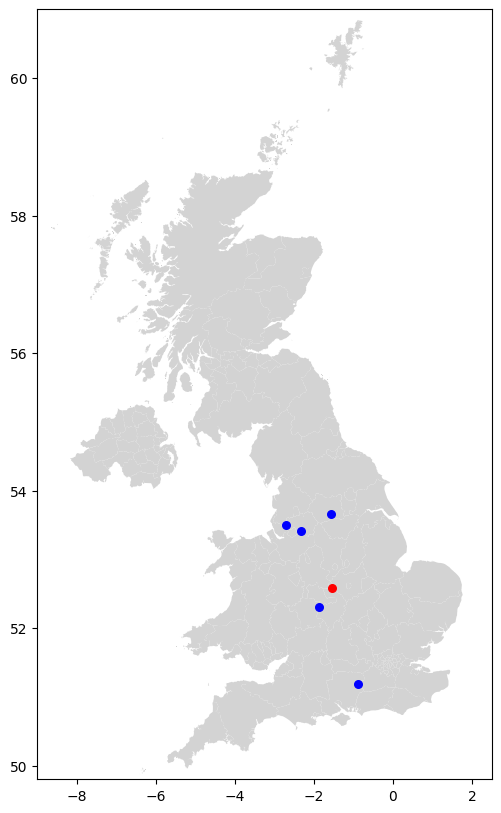

In [34]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

depot_lat = 52.5761527998474
depot_lon = -1.531357028835363

uk_map = gpd.read_file('uk_map/GBR_adm2.shp')

fig, ax = plt.subplots(figsize=(10, 10))
uk_map.plot(ax=ax, color='lightgrey')

gdf = gpd.GeoDataFrame(chosen_items, geometry=gpd.points_from_xy(chosen_items.longitude, chosen_items.latitude))
gdf.plot(ax=ax, marker='o', color='blue', markersize=30)

depot = gpd.GeoDataFrame(geometry=[Point(depot_lon, depot_lat)])
depot.plot(ax=ax, marker='o', color='red', markersize=30)

ax.set_aspect(1.74) # Ratio between latitude and longitude in the UK
ax.set_xlim(-9, 2.5)
ax.set_ylim(49.8, 61)
plt.show()

### Brute Force

In [35]:
from math import sqrt

def distance_between_two_points(p1, p2):
    return sqrt( (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

In [36]:
from collections import defaultdict

def distances_matrix(points):
    n = len(points)
    distances = np.zeros((n, n))
    for i, p1 in enumerate(points):
        for j, p2 in enumerate(points[:i]):
            d = distance_between_two_points(p1, p2)
            distances[i, j] = d
            distances[j, i] = d
    return distances

In [37]:
def total_distance(perm, distances):
    total = 0
    n = len(perm)
    for i in range(n):
        total += distances[perm[i], perm[(i + 1) % n]]
    return total

In [38]:
from itertools import permutations

def brute_force(points):
    # O(n!) - very slow, but will find optimal solution
    # All of this is written in python so is also slow in that way
    distances = distances_matrix(points)
    best_perm = None
    best_dist = float('inf')

    for perm in permutations(range(len(points))):
        dist = total_distance(perm, distances)
        if dist < best_dist:
            best_dist = dist
            best_perm = perm

    return (tuple(points[i] for i in best_perm),
            best_dist)
        

In [39]:
from itertools import permutations

# The UK is small, so we can approximate GPS coordinates as flat coordinates.
points = []
points.append((depot_lat, depot_lon))
points.extend(list(zip(chosen_items['latitude'], chosen_items['longitude'])))

brute_force_route, brute_force_dist = brute_force(points)
print(brute_force_route)
print(brute_force_dist)


((52.5761527998474, -1.531357028835363), (51.187384, -0.887036), (52.301267, -1.882174), (53.499259, -2.703465), (53.415312, -2.323838), (53.659867, -1.560271))
6.751775345117569


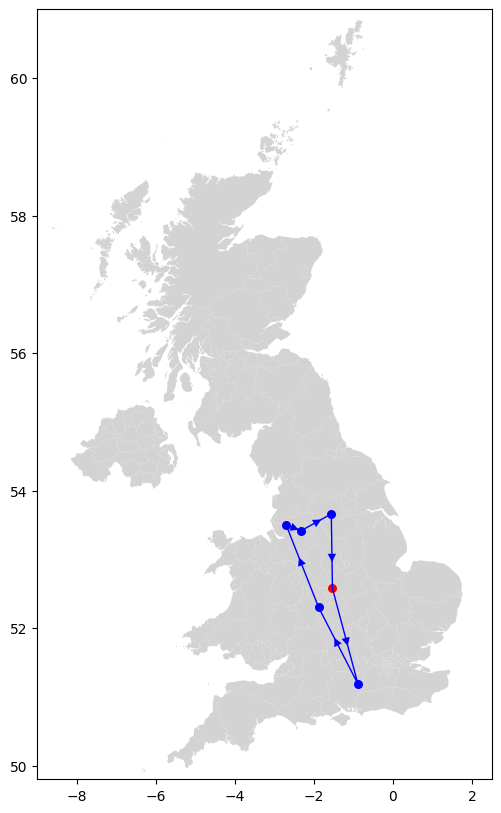

In [40]:
from shapely import LineString
from matplotlib.patches import FancyArrowPatch

def plot_route(route):
    fig, ax = plt.subplots(figsize=(10, 10))
    uk_map.plot(ax=ax, color='lightgrey')

    looped_points = route + (route[0],)
    line = LineString([Point(lon, lat) for lat, lon in looped_points])
    gdf_line = gpd.GeoDataFrame(geometry=[line])

    gdf.plot(ax=ax, marker='o', color='blue', markersize=30)
    depot.plot(ax=ax, marker='o', color='red', markersize=30)
    gdf_line.plot(ax=ax, color='blue', linewidth=1)
    
    x, y = line.xy
    for i in range(len(x)-1):
        mid_x = (x[i] + x[i+1]) / 2
        mid_y = (y[i] + y[i+1]) / 2
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]

        length = np.hypot(dx, dy)
        if length != 0:
            dx /= length
            dy /= length

        arrow = FancyArrowPatch((mid_x, mid_y), (mid_x + dx*0.2, mid_y + dy*0.2),
                                arrowstyle='-|>', mutation_scale=15, color='blue', lw=0)
        ax.add_patch(arrow)

    ax.set_aspect(1.74) # Ratio between latitude and longitude in the UK
    ax.set_xlim(-9, 2.5)
    ax.set_ylim(49.8, 61)
    plt.show()
    
plot_route(brute_force_route)

### Nearest Neighbour

((52.5761527998474, -1.531357028835363), (52.301267, -1.882174), (53.415312, -2.323838), (53.499259, -2.703465), (53.659867, -1.560271), (51.187384, -0.887036))
7.2807624709983205


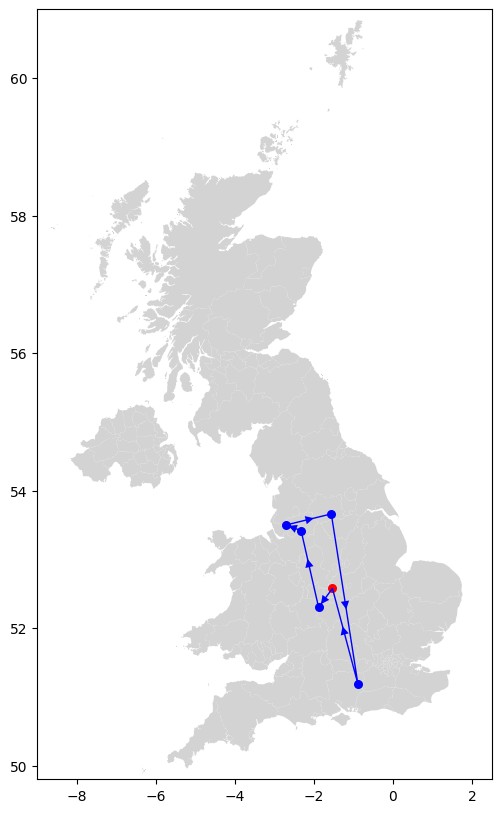

In [41]:
def nearest_neighbour(points):
    # O(n^2) - a lot faster, but not guaranteed to find optimal solution
    distances = distances_matrix(points)
    path_dist = 0
    indices = list(range(len(points)))
    path = [indices.pop(0)]
    while indices:
        best_dist = float('inf')
        best_i = -1
        for i, j in enumerate(indices):
            dist = distances[path[-1], j]
            if dist < best_dist:
                best_dist = dist
                best_i = i
        path.append(indices.pop(best_i))
        path_dist += best_dist
    path_dist += distances[path[0], path[-1]]
    return (tuple(points[i] for i in path),
            path_dist)

nearest_neighbour_route, nearest_neighbour_dist = nearest_neighbour(points)
print(nearest_neighbour_route)
print(nearest_neighbour_dist)
plot_route(nearest_neighbour_route)

### Held-Karp Algorithm

In [42]:
import itertools

def held_karp(points):
    # O(n^2 * 2^n) - optimal solution found
    # https://github.com/CarlEkerot/held-karp/blob/master/held-karp.py
    dists = distances_matrix(points)
    n = len(dists)

    C = {}
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            for k in subset:
                prev = bits & ~(1 << k)
                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m, k], m))
                C[(bits, k)] = min(res)

    bits = (2**n - 1) - 1

    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k, 0], k))
    opt, parent = min(res)

    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    path.append(0)
    return tuple(points[i] for i in reversed(path)), opt

held_karp_route, held_karp_dist = held_karp(points)
# Should be the same result as brute force
assert held_karp_route == brute_force_route
assert held_karp_dist == brute_force_dist

### Time Comparison

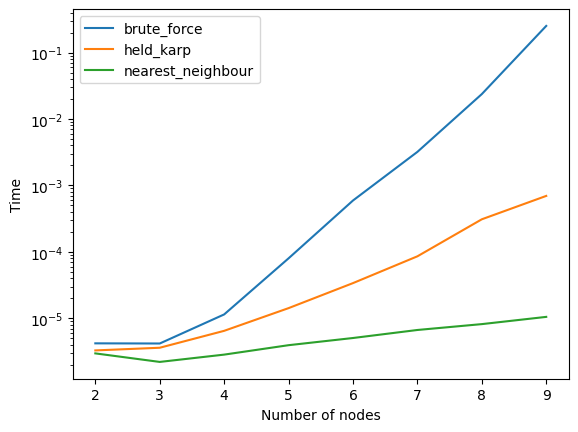

In [43]:
import time

points_all = list(zip(df['latitude'], df['longitude']))
n_runs = 10
xs = list(range(2, 10))
for func in (brute_force, held_karp, nearest_neighbour):
    ys = []
    for i in xs:
        times = []
        for run in range(3):
            start = time.monotonic()
            func(points_all[:i])
            duration = time.monotonic() - start
            times.append(duration)
        ys.append(sum(times)/n_runs)
    plt.plot(xs, ys, label=func.__name__)
    
plt.xlabel("Number of nodes")
plt.ylabel("Time")
plt.yscale('log')
plt.legend()
plt.show()